## **Model with and without original background** **data**


Device: cuda
Classes: ['Blight', 'Healthy', 'Spot']
[Epoch 1/50] Train Acc: 0.8640, Val Acc: 0.9744
Saved best model.
[Epoch 2/50] Train Acc: 0.9852, Val Acc: 0.9615
[Epoch 3/50] Train Acc: 0.9894, Val Acc: 0.8718
[Epoch 4/50] Train Acc: 0.9646, Val Acc: 0.9615
[Epoch 5/50] Train Acc: 0.9677, Val Acc: 0.9744
[Epoch 6/50] Train Acc: 0.9947, Val Acc: 0.9872
Saved best model.
[Epoch 7/50] Train Acc: 0.9968, Val Acc: 0.9872
[Epoch 8/50] Train Acc: 0.9979, Val Acc: 0.9744
[Epoch 9/50] Train Acc: 0.9947, Val Acc: 0.9744
[Epoch 10/50] Train Acc: 0.9963, Val Acc: 0.9872
[Epoch 11/50] Train Acc: 0.9974, Val Acc: 0.9744
[Epoch 12/50] Train Acc: 0.9979, Val Acc: 0.9744
[Epoch 13/50] Train Acc: 0.9984, Val Acc: 0.9744
[Epoch 14/50] Train Acc: 0.9989, Val Acc: 0.9872
[Epoch 15/50] Train Acc: 0.9979, Val Acc: 0.9872
[Epoch 16/50] Train Acc: 0.9942, Val Acc: 0.9615
[Epoch 17/50] Train Acc: 0.9841, Val Acc: 0.9744
[Epoch 18/50] Train Acc: 0.9942, Val Acc: 0.9744
[Epoch 19/50] Train Acc: 0.9958, Val Ac

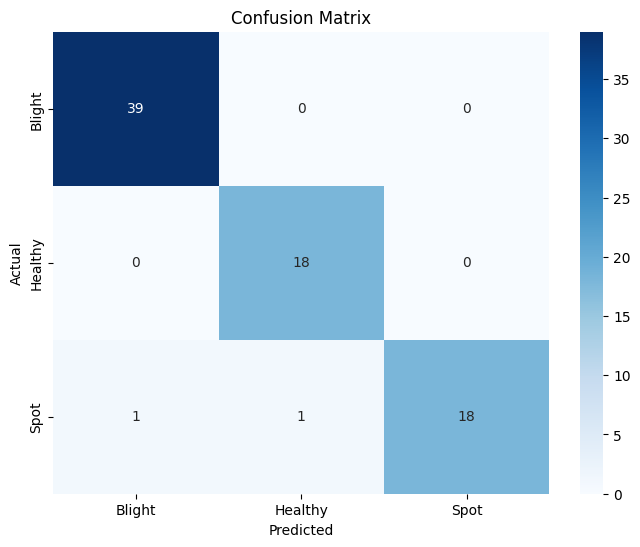

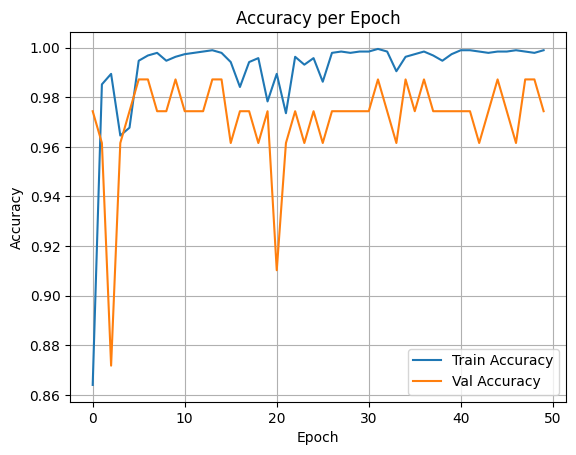

In [ ]:
# =========================
# MaxViT Classification + Full Evaluation+ with original background
# =========================

import os, copy
import torch, timm
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, recall_score, precision_score)

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Paths
DATA_DIR = "/content/drive/MyDrive/my Collected Dataset/Kandahar-maize_Diseases_datset With Background"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VALID_DIR = os.path.join(DATA_DIR, "valid")
TEST_DIR  = os.path.join(DATA_DIR, "test")

# Hyperparameters
IMG_SIZE = 224
BATCH = 32
NUM_EPOCHS = 50
PATIENCE = 7
LR = 1e-4
WEIGHT_DECAY = 1e-5
MODEL_SAVE = "/content/best_maxvit.pth"

# Albumentations transforms
train_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Rotate(15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ToTensorV2()
])
val_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ToTensorV2()
])

# Albumentations Dataset wrapper
class AlbDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.dataset = datasets.ImageFolder(root=root)
        self.transform = transform
        self.classes = self.dataset.classes
    def __len__(self): return len(self.dataset)
    def __getitem__(self, idx):
        img_path, label = self.dataset.samples[idx]
        img = np.array(Image.open(img_path).convert("RGB"))
        if self.transform: img = self.transform(image=img)['image']
        return img, label

# DataLoaders
train_loader = DataLoader(AlbDataset(TRAIN_DIR, train_tfms), batch_size=BATCH, shuffle=True, num_workers=2)
val_loader   = DataLoader(AlbDataset(VALID_DIR, val_tfms), batch_size=BATCH, shuffle=False, num_workers=2)
test_loader  = DataLoader(AlbDataset(TEST_DIR, val_tfms), batch_size=BATCH, shuffle=False, num_workers=2)

num_classes = len(train_loader.dataset.classes)
print("Classes:", train_loader.dataset.classes)

# Model
backbone = timm.create_model("maxvit_tiny_rw_224", pretrained=True, num_classes=0, global_pool="")
class MaxViTClassifier(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.backbone.num_features, num_classes)
    def forward(self, x):
        x = self.backbone.forward_features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

model = MaxViTClassifier(backbone, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Training loop
best_val_acc = 0.0
train_acc_hist, val_acc_hist = [], []

for epoch in range(NUM_EPOCHS):
    # Train
    model.train()
    correct, total = 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward(); optimizer.step()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_acc = correct / total
    train_acc_hist.append(train_acc)

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct / val_total
    val_acc_hist.append(val_acc)

    print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_SAVE)
        print("Saved best model.")

print("Training complete. Best Val Accuracy:", best_val_acc)

# Load best model
model.load_state_dict(torch.load(MODEL_SAVE))
model.eval()

# Evaluation on Test set
all_labels, all_preds = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_loader.dataset.classes))

# Metrics
f1 = f1_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')

print(f"F1 Score: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=train_loader.dataset.classes,
            yticklabels=train_loader.dataset.classes,
            cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()

# Accuracy per epoch plot
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(val_acc_hist, label="Val Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend(); plt.grid(True); plt.show()


# *Analysis of model on Without original background data*
---



In [ ]:
# =========================
# MaxViT Classification + Full Evaluation+ without original backgroung
# =========================

import os, copy
import torch, timm
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, recall_score, precision_score)

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Paths
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/Kandahar-Maize-Dataset.without Background"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VALID_DIR = os.path.join(DATA_DIR, "valid")
TEST_DIR  = os.path.join(DATA_DIR, "test")

# Hyperparameters
IMG_SIZE = 224
BATCH = 32
NUM_EPOCHS = 50
PATIENCE = 7
LR = 1e-4
WEIGHT_DECAY = 1e-5
MODEL_SAVE = "/content/best_maxvit.pth"

# Albumentations transforms
train_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Rotate(15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ToTensorV2()
])
val_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ToTensorV2()
])

# Albumentations Dataset wrapper
class AlbDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.dataset = datasets.ImageFolder(root=root)
        self.transform = transform
        self.classes = self.dataset.classes
    def __len__(self): return len(self.dataset)
    def __getitem__(self, idx):
        img_path, label = self.dataset.samples[idx]
        img = np.array(Image.open(img_path).convert("RGB"))
        if self.transform: img = self.transform(image=img)['image']
        return img, label

# DataLoaders
train_loader = DataLoader(AlbDataset(TRAIN_DIR, train_tfms), batch_size=BATCH, shuffle=True, num_workers=2)
val_loader   = DataLoader(AlbDataset(VALID_DIR, val_tfms), batch_size=BATCH, shuffle=False, num_workers=2)
test_loader  = DataLoader(AlbDataset(TEST_DIR, val_tfms), batch_size=BATCH, shuffle=False, num_workers=2)

num_classes = len(train_loader.dataset.classes)
print("Classes:", train_loader.dataset.classes)

# Model
backbone = timm.create_model("maxvit_tiny_rw_224", pretrained=True, num_classes=0, global_pool="")
class MaxViTClassifier(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.backbone.num_features, num_classes)
    def forward(self, x):
        x = self.backbone.forward_features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

model = MaxViTClassifier(backbone, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Training loop
best_val_acc = 0.0
train_acc_hist, val_acc_hist = [], []

for epoch in range(NUM_EPOCHS):
    # Train
    model.train()
    correct, total = 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward(); optimizer.step()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_acc = correct / total
    train_acc_hist.append(train_acc)

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct / val_total
    val_acc_hist.append(val_acc)

    print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_SAVE)
        print("Saved best model.")

print("Training complete. Best Val Accuracy:", best_val_acc)

# Load best model
model.load_state_dict(torch.load(MODEL_SAVE))
model.eval()

# Evaluation on Test set
all_labels, all_preds = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_loader.dataset.classes))

# Metrics
f1 = f1_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')

print(f"F1 Score: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=train_loader.dataset.classes,
            yticklabels=train_loader.dataset.classes,
            cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()

# Accuracy per epoch plot
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(val_acc_hist, label="Val Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend(); plt.grid(True); plt.show()


# analysis of model on combined data

In [ ]:
# =========================
# MaxViT Classification + Full Evaluation+ Combined data

import os, copy
import torch, timm
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, recall_score, precision_score)

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Paths
DATA_DIR = "/content/drive/MyDrive/my Collected Dataset/combined (Field actual dataset + PlantVillage dataset)"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VALID_DIR = os.path.join(DATA_DIR, "valid")
TEST_DIR  = os.path.join(DATA_DIR, "test")

# Hyperparameters
IMG_SIZE = 224
BATCH = 32
NUM_EPOCHS = 50
PATIENCE = 7
LR = 1e-4
WEIGHT_DECAY = 1e-5
MODEL_SAVE = "/content/best_maxvit.pth"

# Albumentations transforms
train_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Rotate(15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ToTensorV2()
])
val_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ToTensorV2()
])

# Albumentations Dataset wrapper
class AlbDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.dataset = datasets.ImageFolder(root=root)
        self.transform = transform
        self.classes = self.dataset.classes
    def __len__(self): return len(self.dataset)
    def __getitem__(self, idx):
        img_path, label = self.dataset.samples[idx]
        img = np.array(Image.open(img_path).convert("RGB"))
        if self.transform: img = self.transform(image=img)['image']
        return img, label

# DataLoaders
train_loader = DataLoader(AlbDataset(TRAIN_DIR, train_tfms), batch_size=BATCH, shuffle=True, num_workers=2)
val_loader   = DataLoader(AlbDataset(VALID_DIR, val_tfms), batch_size=BATCH, shuffle=False, num_workers=2)
test_loader  = DataLoader(AlbDataset(TEST_DIR, val_tfms), batch_size=BATCH, shuffle=False, num_workers=2)

num_classes = len(train_loader.dataset.classes)
print("Classes:", train_loader.dataset.classes)

# Model
backbone = timm.create_model("maxvit_tiny_rw_224", pretrained=True, num_classes=0, global_pool="")
class MaxViTClassifier(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.backbone.num_features, num_classes)
    def forward(self, x):
        x = self.backbone.forward_features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

model = MaxViTClassifier(backbone, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Training loop
best_val_acc = 0.0
train_acc_hist, val_acc_hist = [], []

for epoch in range(NUM_EPOCHS):
    # Train
    model.train()
    correct, total = 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward(); optimizer.step()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_acc = correct / total
    train_acc_hist.append(train_acc)

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct / val_total
    val_acc_hist.append(val_acc)

    print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_SAVE)
        print("Saved best model.")

print("Training complete. Best Val Accuracy:", best_val_acc)

# Load best model
model.load_state_dict(torch.load(MODEL_SAVE))
model.eval()

# Evaluation on Test set
all_labels, all_preds = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_loader.dataset.classes))

# Metrics
f1 = f1_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')

print(f"F1 Score: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=train_loader.dataset.classes,
            yticklabels=train_loader.dataset.classes,
            cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()

# Accuracy per epoch plot
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(val_acc_hist, label="Val Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend(); plt.grid(True); plt.show()
